In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import json
import requests

from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice

KeyboardInterrupt: 

In [28]:
df = pd.read_csv('dataset/ratings_Electronics (1).csv',names= ['userId', 'productId', 'Rating', 'timestamp'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [30]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month

df['Rating'] = df['Rating'].astype(int)
df['userId'] = df['userId'].astype('str')
df['productId'] = df['productId'].astype('str')

In [31]:
df

,userId,productId,Rating,timestamp,Year,Month
0,AKM1MP6P0OYPR,0132793040,5,2013-04-13,2013,4
1,A2CX7LUOHB2NDG,0321732944,5,2012-07-01,2012,7
2,A2NWSAGRHCP8N5,0439886341,1,2013-04-29,2013,4
3,A2WNBOD3WNDNKT,0439886341,3,2013-07-22,2013,7
4,A1GI0U4ZRJA8WN,0439886341,1,2012-04-18,2012,4
...,...,...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5,2014-04-04,2014,4
7824478,A322MDK0M89RHN,BT008UKTMW,5,2011-08-15,2011,8
7824479,A1MH90R0ADMIK0,BT008UKTMW,4,2014-07-01,2014,7
7824480,A10M2KEFPEQDHN,BT008UKTMW,4,2011-02-13,2011,2


In [32]:
df.isna().sum()

userId       0
productId    0
Rating       0
timestamp    0
Year         0
Month        0
dtype: int64

In [33]:
df.duplicated().sum()

0

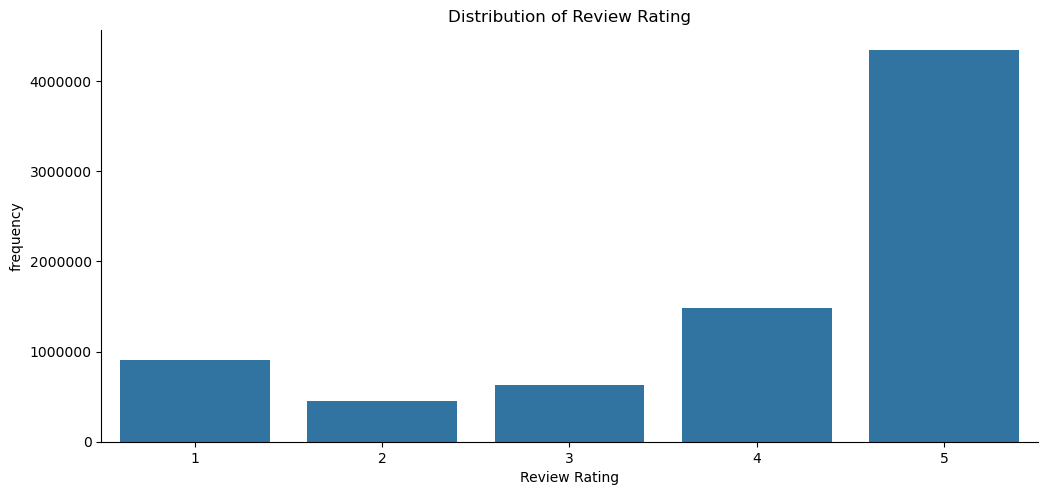

In [34]:
sns.catplot(x=df['Rating'], aspect=2, data=df, kind='count')
plt.title('Distribution of Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

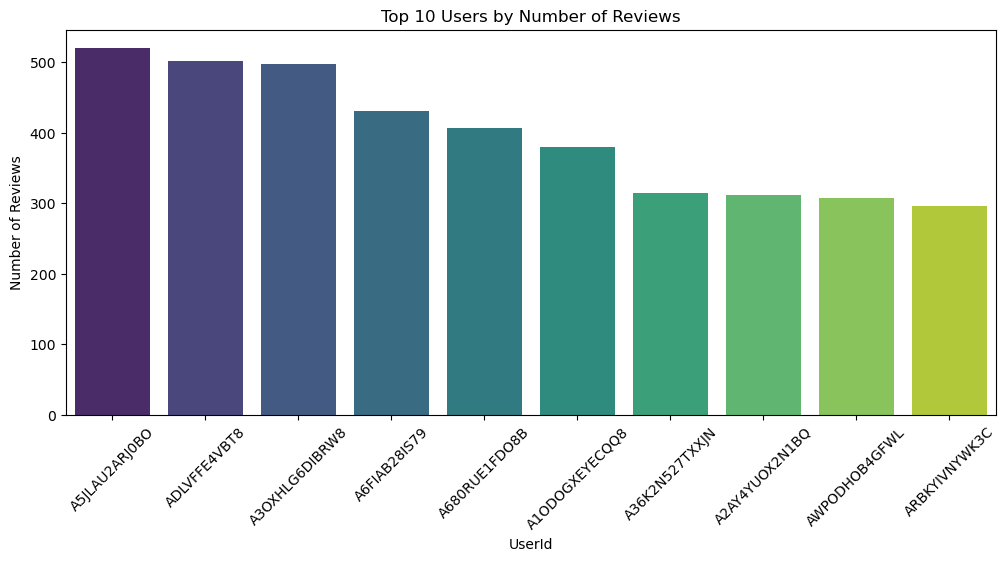

In [35]:
top_users = df['userId'].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index, y=top_users.values, hue=top_users.index, palette='viridis', dodge=False)
plt.title('Top 10 Users by Number of Reviews')
plt.xlabel('UserId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

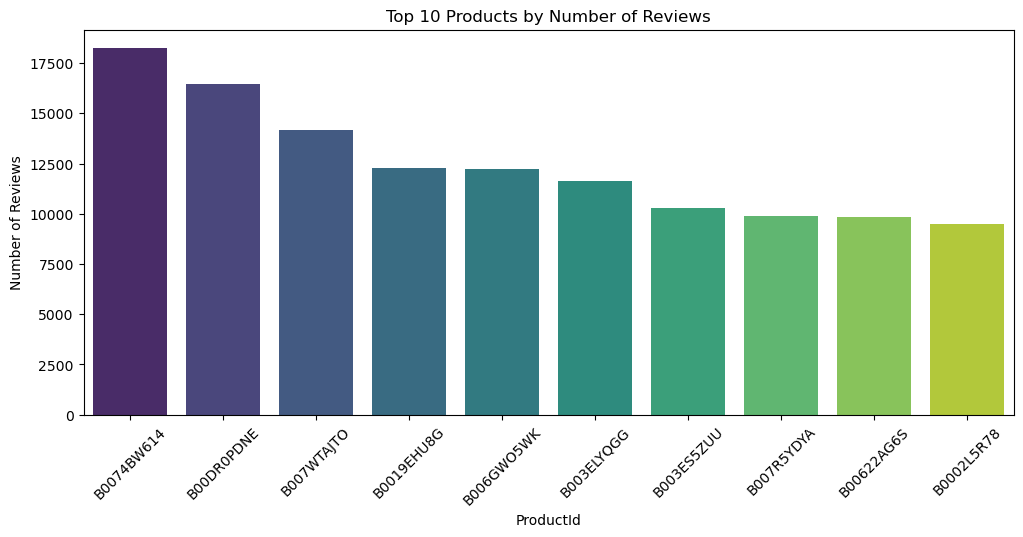

In [36]:
top_products = df['productId'].value_counts().head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_products.index, y=top_products.values, hue=top_products.index, palette='viridis')
plt.title('Top 10 Products by Number of Reviews')
plt.xlabel('ProductId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

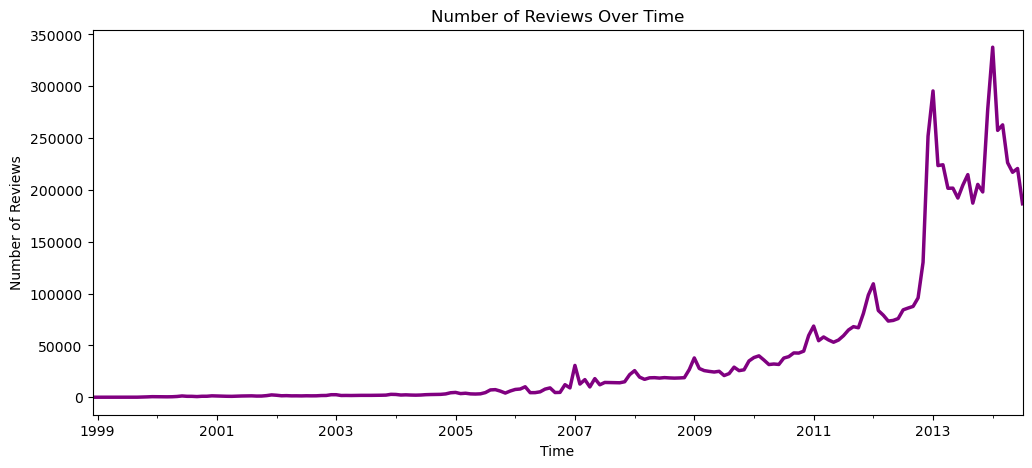

In [37]:
plt.figure(figsize=(12, 5))
df.groupby(df['timestamp'].dt.to_period('M')).size().plot(kind='line', linewidth =2.5, color='purple')
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

In [38]:
ratings_count = df.groupby('productId')['Rating'].count()

popular_products = ratings_count[ratings_count >= 1000].index

df_new = df[df['productId'].isin(popular_products)]

df = df.drop(columns=['timestamp'])

df_new.shape

(7824482, 5)

In [39]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_new[['userId','productId','Rating']],reader)

trainset, testset =train_test_split(data, test_size=0.2, random_state=0) 

In [40]:
model = SVD(n_epochs= 10, lr_all= 0.005, reg_all= 0.4)
model.fit(trainset)

In [41]:
predictions = model.test(testset)

accuracy.rmse(predictions)

RMSE: 1.1959


1.1958740605521836

In [42]:
# from surprise.model_selection import GridSearchCV
# para_grid = {
#     'n_epochs': [5, 10],
#     'lr_all': [0.002, 0.005],
#     'reg_all': [0.4, 0.6]
# }

# gs = GridSearchCV(SVD, para_grid, measures=['rmse'], cv=3)

# gs.fit(data)

# print('Best RMSE:', gs.best_score['rmse'])

# print('Best parameters:', gs.best_params['rmse'])

Best parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [43]:
import pickle

filename= 'model/recommendation_model_svd.pkl'

pickle.dump(model, open(filename, 'wb'))

In [44]:
loaded_model= pickle.load(open(filename, 'rb'))

In [45]:
import random

random.seed(0)

random_test_samples = random.sample(testset, 10)

predictions = [model.predict(uid, iid, r_ui) for (uid, iid, r_ui) in random_test_samples]


for prediction in predictions:
    if prediction.est > 4:
        rec = True
    else:
        rec = False
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Actual Rating: {prediction.r_ui}, Predicted Rating: {prediction.est:.2f}, recommended for you: {rec}")

User: A3H7FEKB32IKH7, Item: B0074BW614, Actual Rating: 5.0, Predicted Rating: 4.41, recommended for you: True
User: A2WD6FD379LOKX, Item: B003XM73P2, Actual Rating: 5.0, Predicted Rating: 4.52, recommended for you: True
User: A3ON7EYG49ICE3, Item: B000HPV3RW, Actual Rating: 5.0, Predicted Rating: 4.39, recommended for you: True
User: A36B3WJRCXH4SF, Item: B0098F5W0Q, Actual Rating: 5.0, Predicted Rating: 4.21, recommended for you: True
User: AJRBAXC2H0396, Item: B002HMWQE2, Actual Rating: 1.0, Predicted Rating: 3.57, recommended for you: False
User: A38XWFP5CQUIWU, Item: B007R5YDYA, Actual Rating: 5.0, Predicted Rating: 4.54, recommended for you: True
User: AVOCNUFOXUCA6, Item: B00119T6NQ, Actual Rating: 5.0, Predicted Rating: 4.16, recommended for you: True
User: A3PVOHJCEVJZT9, Item: B003DZ1684, Actual Rating: 3.0, Predicted Rating: 4.39, recommended for you: True
User: A1L449ANLVYIEC, Item: B004QK7HI8, Actual Rating: 5.0, Predicted Rating: 4.10, recommended for you: True
User: A3QLR